In [141]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')


In [142]:
env = gym.make('CartPole-v0')


In [143]:
dim = max(np.shape(env.observation_space))
dim_actions = env.action_space.n
env.observation_space.shape

env.reward_range


(-inf, inf)

In [144]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, shape=[None, dim], name="state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=self.state,
                num_outputs=dim_actions,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        
        state = np.reshape(state,(1,dim)) # Change the observation file to input
            
        return sess.run(self.action_probs, feed_dict={ self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        
        state = np.reshape(state,(1,dim)) # Change the observation file to input

        
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [145]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, shape=[None, dim], name="state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=self.state,
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
                
        state = np.reshape(state,(1,dim)) # Change the observation file to input
        
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        
        state = np.reshape(state,(1,dim)) # Change the observation file to input

        
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [152]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        #print(state)
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            next_state, reward, done, _ = env.step(action)
            
            #env.render()
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            #print(reward)
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()

            if done:
                break
                
            state = next_state
    
        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # The return after this timestep
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            #print(total_return)
            # Calculate baseline/advantage
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            # Update our value estimator
            estimator_value.update(transition.state, total_return)
            # Update our policy estimator
            estimator_policy.update(transition.state, advantage, transition.action)
    
    return stats

In [156]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = reinforce(env, policy_estimator, value_estimator, 2000, discount_factor=0.9)
    
    
    ## TEST THE OBTAINED POLICY

    state = env.reset()

    while(1):

        # Take a step
        action_probs = policy_estimator.predict(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        next_state, reward, done, _ = env.step(action)
        env.render()

        if done:
            break

        state = next_state

Step 47 @ Episode 1/2000 (0.0)48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 24 @ Episode 2/2000 (48.0)25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 57 @ Episode 3/2000 (25.0)58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 50 @ Episode 4/2000 (58.0)51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Ste

77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 130 @ Episode 32/2000 (91.0)131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0

101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 96 @ Episode 51/2000 (150.0)97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2

Step 88 @ Episode 72/2000 (191.0)89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 75 @ Episode 73/2000 (89.0)76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 77 @ Episode 74/2000 (76.0)78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
5

142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 175 @ Episode 88/2000 (200.0)176.0
175.0
174.0
173.0
172.0
171.0
170.0
169.0
168.0
167.0
166.0
165.0
164.0
163.0
162.0
161.0
160.0
159.0
158.0
157.0
156.0
155.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0


8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 89 @ Episode 101/2000 (99.0)90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 64 @ Episode 102/2000 (90.0)65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 69 @ Episode 103/2000 (65.0)70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48

19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 25 @ Episode 117/2000 (30.0)26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 48 @ Episode 118/2000 (26.0)49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 43 @ Episode 119/2000 (49.0)44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 21 @ Episode 120/2000 (44.0)22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 32 @ Episode 121/2000 (22.0)33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0


11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 119 @ Episode 140/2000 (108.0)120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 98 @ Episode 141/2000 (120.0)99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.

55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 168 @ Episode 152/2000 (154.0)169.0
168.0
167.0
166.0
165.0
164.0
163.0
162.0
161.0
160.0
159.0
158.0
157.0
156.0
155.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0

Step 65 @ Episode 165/2000 (71.0)66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 74 @ Episode 166/2000 (66.0)75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 77 @ Episode 167/2000 (75.0)78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0

23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 133 @ Episode 188/2000 (139.0)134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 150 @ Episode 189/2000 (134.0)151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
13

Step 198 @ Episode 200/2000 (122.0)199.0
198.0
197.0
196.0
195.0
194.0
193.0
192.0
191.0
190.0
189.0
188.0
187.0
186.0
185.0
184.0
183.0
182.0
181.0
180.0
179.0
178.0
177.0
176.0
175.0
174.0
173.0
172.0
171.0
170.0
169.0
168.0
167.0
166.0
165.0
164.0
163.0
162.0
161.0
160.0
159.0
158.0
157.0
156.0
155.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0


17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 44 @ Episode 246/2000 (29.0)45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 31 @ Episode 247/2000 (45.0)32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 22 @ Episode 248/2000 (32.0)23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 24 @ Episode 249/2000 (23.0)25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 23 @ Episode 250/2000 (25.0)24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 21 @ Episode 251/2000 (24.0)22.0
21.0
20.0
19.0
18.0
1

13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 47 @ Episode 290/2000 (57.0)48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 56 @ Episode 291/2000 (48.0)57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 37 @ Episode 292/2000 (57.0)38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 40 @ Episode 293/2000 (38.0)41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0

9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 47 @ Episode 323/2000 (80.0)48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 30 @ Episode 324/2000 (48.0)31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 40 @ Episode 325/2000 (31.0)41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 45 @ Episode 326/2000 (41.0)46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 47 @ Episode 327/2000 (46.0)48.0


Step 92 @ Episode 346/2000 (105.0)93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 66 @ Episode 347/2000 (93.0)67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 61 @ Episode 348/2000 (67.0)62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.

Step 51 @ Episode 365/2000 (101.0)52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 64 @ Episode 366/2000 (52.0)65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 110 @ Episode 367/2000 (65.0)111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0


44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 40 @ Episode 384/2000 (72.0)41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 123 @ Episode 385/2000 (41.0)124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
2

Step 84 @ Episode 402/2000 (72.0)85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 75 @ Episode 403/2000 (85.0)76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 70 @ Episode 404/2000 (76.0)71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0

15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 104 @ Episode 420/2000 (81.0)105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 121 @ Episode 421/2000 (105.0)122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0


26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 104 @ Episode 439/2000 (92.0)105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 107 @ Episode 440/2000 (105.0)108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0

20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 50 @ Episode 463/2000 (48.0)51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 59 @ Episode 464/2000 (51.0)60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 52 @ Episode 465/2000 (60.0)53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 49 @ Episode

72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 52 @ Episode 490/2000 (91.0)53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 69 @ Episode 491/2000 (53.0)70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.

Step 89 @ Episode 511/2000 (96.0)90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 89 @ Episode 512/2000 (90.0)90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 94 @ Episode 513/2000 (90.0)95.0
94.0
93.0
92.0

Step 146 @ Episode 532/2000 (58.0)147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 71 @ Episode 533/2000 (147.0)72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.

91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 67 @ Episode 554/2000 (93.0)68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 163 @ Episode 555/2000 (68.0)164.0
163.0
162.0
161.0
160.0
159.0
158.0
157.0
156.0
155.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0


9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 55 @ Episode 571/2000 (74.0)56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 75 @ Episode 572/2000 (56.0)76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 63 @ Episode 573/2000 (76.0)64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.

44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 75 @ Episode 591/2000 (105.0)76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 56 @ Episode 592/2000 (76.0)57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 52 @ Episode 593/2000 (57.0)53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45

Step 59 @ Episode 612/2000 (56.0)60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 48 @ Episode 613/2000 (60.0)49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 96 @ Episode 614/2000 (49.0)97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0

27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 56 @ Episode 634/2000 (64.0)57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 100 @ Episode 635/2000 (57.0)101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 75 @ Episode 636/2000 (101.0

16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 103 @ Episode 656/2000 (81.0)104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 67 @ Episode 657/2000 (104.0)68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 77 @ Epis

Step 105 @ Episode 675/2000 (53.0)106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 78 @ Episode 676/2000 (106.0)79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 70 @ Episode 

92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 105 @ Episode 695/2000 (102.0)106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.

92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 89 @ Episode 708/2000 (139.0)90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 48 @ Episode 709/2000 (90.0)49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
4

5.0
4.0
3.0
2.0
1.0
Step 31 @ Episode 743/2000 (31.0)32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 49 @ Episode 744/2000 (32.0)50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 41 @ Episode 745/2000 (50.0)42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 46 @ Episode 746/2000 (42.0)47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 44 @ Episode 747/2000 (4

21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 39 @ Episode 778/2000 (47.0)40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 51 @ Episode 779/2000 (40.0)52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 48 @ Episode 780/2000 (52.0)49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 58 @ Episode 781/2000 (49.0)59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0

84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 70 @ Episode 802/2000 (91.0)71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 47 @ Episode 803/2000 (71.0)48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13

17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 74 @ Episode 824/2000 (104.0)75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 117 @ Episode 825/2000 (75.0)118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
2

39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 68 @ Episode 840/2000 (108.0)69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 103 @ Episode 841/2000 (69.0)104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0


11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 89 @ Episode 858/2000 (87.0)90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 81 @ Episode 859/2000 (90.0)82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 119 @ Episode 860/2000 (82.0)120.0
119.0


30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 107 @ Episode 876/2000 (93.0)108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 82 @ Episode 877/2000 (108.0)83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
3

157.0
156.0
155.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 199 @ Episode 887/2000 (196.0)200.0
199.0
198.0
197.0
196.0
195.0
194.0
193.0
192.0
191.0
190.0
189.0
188.0
187.0
186.0
185.0
184.0
183.0
182.0
181.0
180.0
179.0

Step 76 @ Episode 895/2000 (83.0)77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 166 @ Episode 896/2000 (77.0)167.0
166.0
165.0
164.0
163.0
162.0
161.0
160.0
159.0
158.0
157.0
156.0
155.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0

40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 199 @ Episode 908/2000 (111.0)200.0
199.0
198.0
197.0
196.0
195.0
194.0
193.0
192.0
191.0
190.0
189.0
188.0
187.0
186.0
185.0
184.0
183.0
182.0
181.0
180.0
179.0
178.0
177.0
176.0
175.0
174.0
173.0
172.0
171.0
170.0
169.0
168.0
167.0
166.0
165.0
164.0
163.0
162.0
161.0
160.0
159.0
158.0
157.0
156.0
155.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.

96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 132 @ Episode 921/2000 (161.0)133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0


14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 47 @ Episode 931/2000 (42.0)48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 51 @ Episode 932/2000 (48.0)52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 63 @ Episode 933/2000 (52.0)64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 40 @ Episode 934/2000 (64.0)41.0
40.0
39.0

47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 43 @ Episode 960/2000 (78.0)44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 52 @ Episode 961/2000 (44.0)53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 70 @ Episode 962/2000 (53.0)71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.

82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 55 @ Episode 985/2000 (117.0)56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 85 @ Episode 986/2000 (56.0)86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
3

52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 105 @ Episode 1006/2000 (76.0)106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 71 @ Episode 1007/2000 (106.0)72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
4

35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 73 @ Episode 1024/2000 (81.0)74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 82 @ Episode 1025/2000 (74.0)83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0

Step 135 @ Episode 1040/2000 (139.0)136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 100 @ Episode 1041/2000 (136.0)101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.

Step 117 @ Episode 1055/2000 (87.0)118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 114 @ Episode 1056/2000 (118.0)115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.

Step 95 @ Episode 1069/2000 (200.0)96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 57 @ Episode 1070/2000 (96.0)58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 37 @ Episode 1071/2000 (58.0)38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0


Step 44 @ Episode 1110/2000 (42.0)45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 35 @ Episode 1111/2000 (45.0)36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 41 @ Episode 1112/2000 (36.0)42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 47 @ Episode 1113/2000 (42.0)48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 29 @ Episode 1114/2000 (48.0)30.0
29.0
2

44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 34 @ Episode 1145/2000 (82.0)35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 40 @ Episode 1146/2000 (35.0)41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 64 @ Episode 1147/2000 (41.0)65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 43 @

45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 59 @ Episode 1170/2000 (57.0)60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 101 @ Episode 1171/2000 (60.0)102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
1

Step 90 @ Episode 1188/2000 (72.0)91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 47 @ Episode 1189/2000 (91.0)48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 62 @ Episode 1190/2000 (48.0)63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
1

Step 115 @ Episode 1207/2000 (60.0)116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 59 @ Episode 1208/2000 (116.0)60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 59 @ Episode 1209/2000 (60.0)60.0
59.0
58.0
57

60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 104 @ Episode 1226/2000 (93.0)105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 55 @ Episode 1227/2000 (105.0)56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33

10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 69 @ Episode 1248/2000 (54.0)70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 55 @ Episode 1249/2000 (70.0)56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 55 @ Episode 1250/2000 (56.0)56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.

80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 123 @ Episode 1268/2000 (84.0)124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0

37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 69 @ Episode 1289/2000 (65.0)70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 146 @ Episode 1290/2000 (70.0)147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
7

17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 109 @ Episode 1307/2000 (62.0)110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 171 @ Episode 1308/2000 (110.0)172.0
171.0
170.0
169.0
168.0
167.0
166.0
165.0
164.0
163.0
162.0
161.0
160.0
159.0
158.0
157.0
156.0
155.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
1

18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 69 @ Episode 1327/2000 (55.0)70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 64 @ Episode 1328/2000 (70.0)65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 68 @ Episode 1329/2000 (65.0)69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0


7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 82 @ Episode 1347/2000 (81.0)83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 46 @ Episode 1348/2000 (83.0)47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 77 @ Episode 1349/2000 (47.0)78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.

15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 89 @ Episode 1371/2000 (58.0)90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 102 @ Episode 1372/2000 (90.0)103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0


Step 69 @ Episode 1391/2000 (65.0)70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 64 @ Episode 1392/2000 (70.0)65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 76 @ Episode 1393/2000 (65.0)77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
2

36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 70 @ Episode 1412/2000 (56.0)71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 72 @ Episode 1413/2000 (71.0)73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 134 @ Episode 1414/2000 (73.0)135.0
134.0
133.0
132.0


40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 116 @ Episode 1429/2000 (102.0)117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 98 @ Episode 1430/2000 (117.0)99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0

4.0
3.0
2.0
1.0
Step 85 @ Episode 1444/2000 (111.0)86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 119 @ Episode 1445/2000 (86.0)120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26

6.0
5.0
4.0
3.0
2.0
1.0
Step 28 @ Episode 1458/2000 (40.0)29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 41 @ Episode 1459/2000 (29.0)42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 47 @ Episode 1460/2000 (42.0)48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 46 @ Episode 1461/2000 (48.0)47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 52 @ Episode 1462/2000 (47.0)53.0
52.0
51

15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 48 @ Episode 1489/2000 (43.0)49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 62 @ Episode 1490/2000 (49.0)63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 56 @ Episode 1491/2000 (63.0)57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 46 @ Epis

10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 80 @ Episode 1517/2000 (53.0)81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 76 @ Episode 1518/2000 (81.0)77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 56 @ Episode 1519/2000 (77.0)57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0


54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 84 @ Episode 1534/2000 (83.0)85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 54 @ Episode 1535/2000 (85.0)55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3

17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 69 @ Episode 1553/2000 (117.0)70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 80 @ Episode 1554/2000 (70.0)81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 75 @ Episode 1555/2000 (81.0)76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0

7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 103 @ Episode 1575/2000 (52.0)104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 50 @ Episode 1576/2000 (104.0)51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 44 @ Episode 1577/2000 (51.0)45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
2

42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 43 @ Episode 1598/2000 (86.0)44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 62 @ Episode 1599/2000 (44.0)63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 60 @ Episode 1600/2000 (63.0)61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0


51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 100 @ Episode 1619/2000 (73.0)101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 67 @ Episode 1620/2000 (101.0)68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
3

16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 86 @ Episode 1639/2000 (73.0)87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 63 @ Episode 1640/2000 (87.0)64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 43 @ Episode 1641/2000 (64.0)44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0


54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 131 @ Episode 1663/2000 (61.0)132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 98 @ Episode 16

27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 47 @ Episode 1685/2000 (84.0)48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 79 @ Episode 1686/2000 (48.0)80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 65 @ Episode 1687/2000 (80.0)66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0


61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 83 @ Episode 1711/2000 (85.0)84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 50 @ Episode 1712/2000 (84.0)51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0

33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 173 @ Episode 1734/2000 (53.0)174.0
173.0
172.0
171.0
170.0
169.0
168.0
167.0
166.0
165.0
164.0
163.0
162.0
161.0
160.0
159.0
158.0
157.0
156.0
155.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0

Step 76 @ Episode 1756/2000 (69.0)77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 61 @ Episode 1757/2000 (77.0)62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 61 @ Episode 1758/2000 (62.0)62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
1

Step 68 @ Episode 1777/2000 (86.0)69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 65 @ Episode 1778/2000 (69.0)66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 58 @ Episode 1779/2000 (66.0)59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
1

16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 61 @ Episode 1803/2000 (59.0)62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 82 @ Episode 1804/2000 (62.0)83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 77 @ Episode 1805/2000 (83.0)78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0


8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 62 @ Episode 1827/2000 (77.0)63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 65 @ Episode 1828/2000 (63.0)66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 78 @ Episode 1829/2000 (66.0)79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0

10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 111 @ Episode 1851/2000 (48.0)112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 37 @ Episode 1852/2000 (112.0)38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 53 @ Episode 1853/2000 (38.0)54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0


Step 85 @ Episode 1872/2000 (99.0)86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 71 @ Episode 1873/2000 (86.0)72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 54 @ Episode 1874/2000 (72.0)55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
3

11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 65 @ Episode 1895/2000 (60.0)66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 49 @ Episode 1896/2000 (66.0)50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 54 @ Episode 1897/2000 (50.0)55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 73 @ Episode 1898/2

1.0
Step 70 @ Episode 1917/2000 (100.0)71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 80 @ Episode 1918/2000 (71.0)81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 53 @ Episode 1919/2000 (81.0)54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
2

26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 45 @ Episode 1936/2000 (163.0)46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 52 @ Episode 1937/2000 (46.0)53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 81 @ Episode 1938/2000 (53.0)82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0

30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 91 @ Episode 1960/2000 (80.0)92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 58 @ Episode 1961/2000 (92.0)59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 114 @ Episode 1962/2000 (59.0)115.0
114.0
113.0
1

7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 125 @ Episode 1986/2000 (35.0)126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 96 @ Episode 1987/2000 (126.0)97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0

In [157]:
env.close()

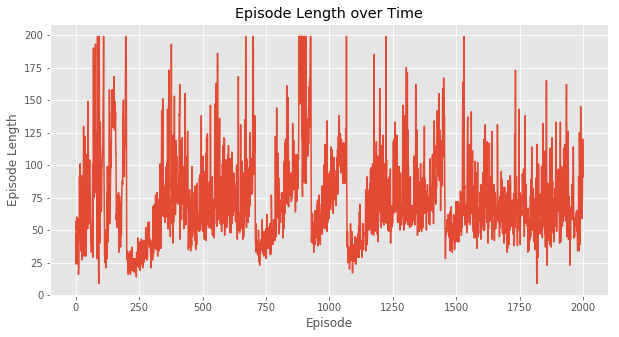

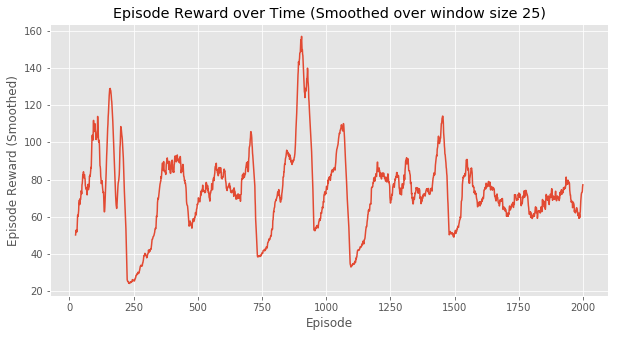

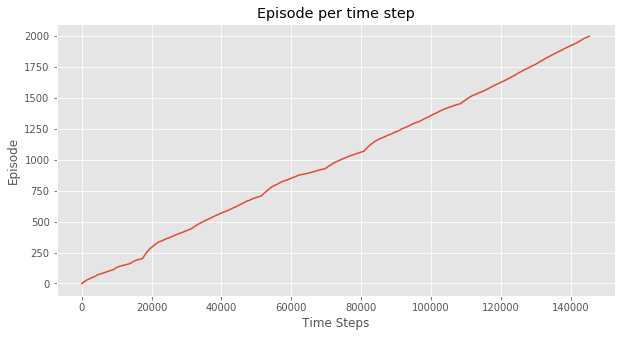

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [158]:
plotting.plot_episode_stats(stats, smoothing_window=25)

In [148]:
## TEST THE EFFECT OF DISCOUNT FACTOR

ones = np.ones(200)

discount = 0.9

total_return = sum(discount**i * t for i, t in enumerate(ones[:]))


FailedPreconditionError: Attempting to use uninitialized value policy_estimator/fully_connected/weights
	 [[node policy_estimator/fully_connected/weights/read (defined at /home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py:277)  = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](policy_estimator/fully_connected/weights)]]

Caused by op 'policy_estimator/fully_connected/weights/read', defined at:
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-147-892e2e841ae0>", line 4, in <module>
    policy_estimator = PolicyEstimator()
  File "<ipython-input-144-3c980d6a6ef1>", line 17, in __init__
    weights_initializer=tf.zeros_initializer)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1854, in fully_connected
    outputs = layer.apply(inputs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 817, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 746, in __call__
    self.build(input_shapes)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py", line 944, in build
    trainable=True)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 288, in add_weight
    getter=vs.get_variable)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 609, in add_weight
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/training/checkpointable/base.py", line 639, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1487, in get_variable
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1237, in get_variable
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 523, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1749, in layer_variable_getter
    return _model_variable_getter(getter, *args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1740, in _model_variable_getter
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 350, in model_variable
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 277, in variable
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 922, in _get_single_variable
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1329, in __init__
    constraint=constraint)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1491, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3454, in identity
    "Identity", input=input, name=name)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value policy_estimator/fully_connected/weights
	 [[node policy_estimator/fully_connected/weights/read (defined at /home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py:277)  = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](policy_estimator/fully_connected/weights)]]


AttributeError: 'NoneType' object has no attribute 'run'